根據 [數據前處理的重要步驟](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0232525) 在數據分析和機器學習中，數據前處理是提高模型性能和數據質量的關鍵步驟。以下列出重要的前處理方法：

1. **停用詞移除**：在許多數據集中，移除頻繁出現但對分類貢獻較低的停用詞，能提升分類準確性。不同語料中停用詞的效用取決於具體語境，可能對某些數據集無益甚至有害。

2. **拼寫錯誤修正**：修正文本中的拼寫錯誤，能減少分類特徵的分散性，提高模型的學習效果。

3. **大小寫轉換**：統一字母大小寫（如將大寫字母轉為小寫）能有效減少特徵冗餘。

4. **標點符號移除**：移除標點符號有助於清理文本，但在某些情境中可能削弱分類準確性。


## 以下實驗將對照前處理對模型的影響

In [ ]:
import pandas as pd
import json
import re
from nltk.corpus import stopwords
import string
from unicodedata import normalize
def clean_data(line):
    if not isinstance(line, str):
        raise ValueError("Input must be a string")
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))
    # 正規化、去除非ASCII字符
    line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
    
    # 分詞、轉為小寫
    line = line.split()
    line = [word.lower() for word in line]
    
    # 去除標點符號
    line = [word.translate(table) for word in line]
    
    # 去除停用詞和非字母詞
    line = [word for word in line if word.isalpha() and word not in stop_words]
    
    # 重組成字串並返回
    return ' '.join(line)
def save_cleaned_data(cleaned_data, output_filepath):
    with open(output_filepath, 'w', encoding='utf-8') as file:
        json.dump(cleaned_data, file, ensure_ascii=False, indent=4)
data = pd.read_json('Origin.json')

for index, row in data.iterrows():
    data.at[index, 'headline'] = clean_data(row['headline'])
    data.at[index, 'short_description'] = clean_data(row['short_description'])

save_cleaned_data(data.to_dict(orient='records'), 'Processed.json')


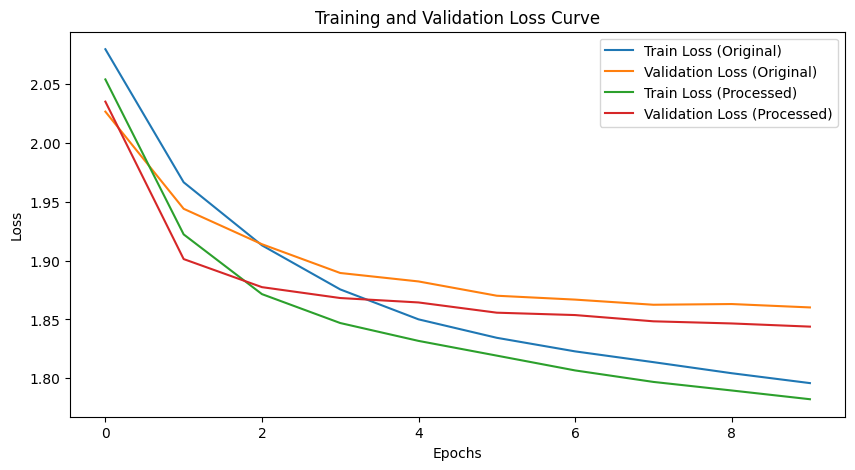

未前處理驗證準確度 0.68
前處理驗證準確度 0.70


In [ ]:
import bilstm
import matplotlib.pyplot as plt
Origin = bilstm.NewsClassificationPipeline(data_path='Origin.json' , num_epochs=10)
Processed = bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10)
Origin.run() 
Processed.run()


train_loss_origin = Origin.train_loss
val_loss_origin = Origin.val_loss

train_loss_processed = Processed.train_loss
val_loss_processed = Processed.val_loss

plt.figure(figsize=(10, 5))
plt.plot(train_loss_origin, label='Train Loss (Original)')
plt.plot(val_loss_origin, label='Validation Loss (Original)')
plt.plot(train_loss_processed, label='Train Loss (Processed)')
plt.plot(val_loss_processed, label='Validation Loss (Processed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print("未前處理驗證準確度 %.2f"%Origin.val_accuracy )
print("前處理驗證準確度 %.2f"%Processed.val_accuracy )

## 特徵選擇
特徵包含 標題 簡述 這裡要比較使用哪些 能有更好得表現


- **headline**: 新聞標題。
- **short_description**: 新聞簡述。

我們將比較這些特徵在模型中的表現，並通過訓練和驗證損失來評估模型性能。

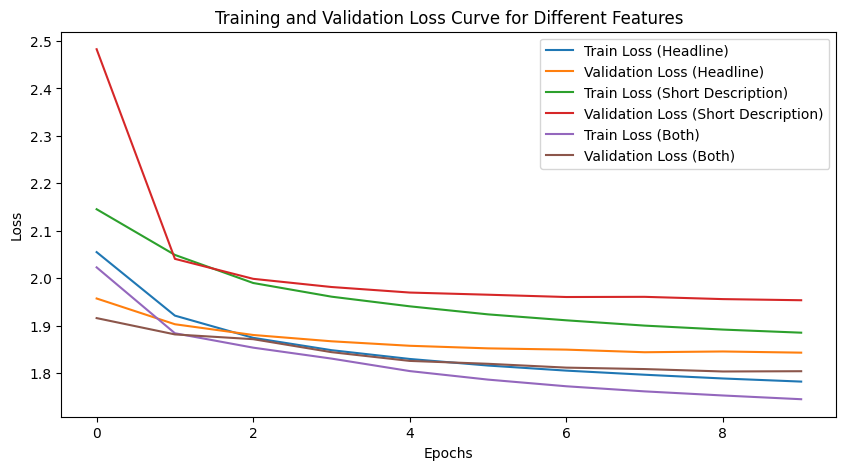

標題驗證準確度 0.70
簡述驗證準確度 0.59
標題和簡述驗證準確度 0.74


In [6]:
import bilstm
import matplotlib.pyplot as plt
headline = bilstm.NewsClassificationPipeline(data_path='Processed.json' , num_epochs= 10 , feature=['headline'])
short_description = bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['short_description'])
both = bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])

headline.run()
short_description.run()
both.run()

train_loss_headline = headline.train_loss
val_loss_headline = headline.val_loss

train_loss_short_description = short_description.train_loss
val_loss_short_description = short_description.val_loss

train_loss_both = both.train_loss
val_loss_both = both.val_loss

plt.figure(figsize=(10, 5))
plt.plot(train_loss_headline, label='Train Loss (Headline)')
plt.plot(val_loss_headline, label='Validation Loss (Headline)')
plt.plot(train_loss_short_description, label='Train Loss (Short Description)')
plt.plot(val_loss_short_description, label='Validation Loss (Short Description)')
plt.plot(train_loss_both, label='Train Loss (Both)')
plt.plot(val_loss_both, label='Validation Loss (Both)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for Different Features')
plt.legend()
plt.show()

print("標題驗證準確度 %.2f" % headline.val_accuracy)
print("簡述驗證準確度 %.2f" % short_description.val_accuracy)
print("標題和簡述驗證準確度 %.2f" % both.val_accuracy)

## 比較其他常用模型 text classfication 模型
在本實驗中，我們將比較三種常用的文本分類模型：BiLSTM、BiGRU 和 TextCNN。這些模型在處理自然語言處理任務時各有優勢，我們將通過訓練和驗證損失來評估它們的性能。

- **BiLSTM**: 雙向長短期記憶網絡，能夠捕捉文本的長期依賴關係。
- **BiGRU**: 雙向門控循環單元，與 BiLSTM 類似，但計算效率更高。
- **TextCNN**: 基於卷積神經網絡的文本分類模型，擅長捕捉局部特徵。

我們將使用相同的數據集和相同的訓練參數來進行比較，並通過損失曲線和驗證準確度來評估模型性能。

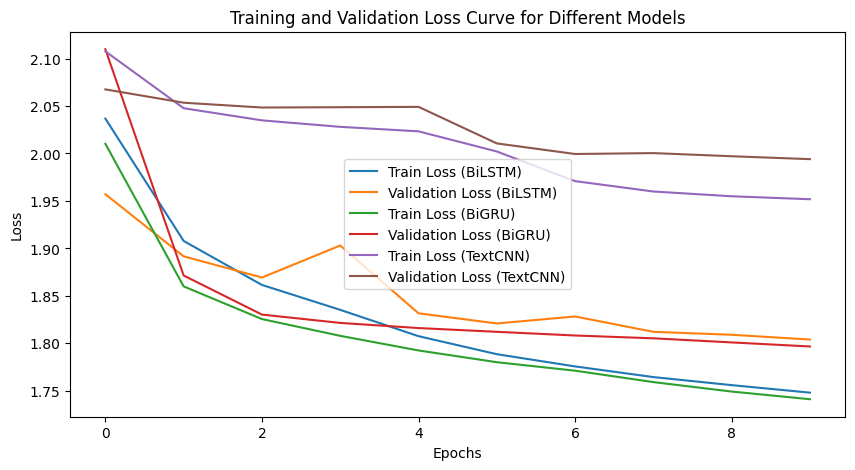

BiLSTM 驗證準確度 0.74
BiGRU 驗證準確度 0.75
TextCNN 驗證準確度 0.55


In [1]:
import bigru
import bilstm
import textcnn
import matplotlib.pyplot as plt
lstm = bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
gru = bigru.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
cnn = textcnn.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])


lstm.run()
gru.run()
cnn.run()

train_loss_lstm = lstm.train_loss
val_loss_lstm = lstm.val_loss

train_loss_gru = gru.train_loss
val_loss_gru = gru.val_loss

train_loss_cnn = cnn.train_loss
val_loss_cnn = cnn.val_loss

plt.figure(figsize=(10, 5))
plt.plot(train_loss_lstm, label='Train Loss (BiLSTM)')
plt.plot(val_loss_lstm, label='Validation Loss (BiLSTM)')
plt.plot(train_loss_gru, label='Train Loss (BiGRU)')
plt.plot(val_loss_gru, label='Validation Loss (BiGRU)')
plt.plot(train_loss_cnn, label='Train Loss (TextCNN)')
plt.plot(val_loss_cnn, label='Validation Loss (TextCNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for Different Models')
plt.legend()
plt.show()

print("BiLSTM 驗證準確度 %.2f" % lstm.val_accuracy)
print("BiGRU 驗證準確度 %.2f" % gru.val_accuracy)
print("TextCNN 驗證準確度 %.2f" % cnn.val_accuracy)


## 模型與嵌入方法

| 模型                   | 嵌入方法               | 描述                                                                   |
|------------------------|------------------------|------------------------------------------------------------------------|
| **BiLSTM**            | 詞頻 (TF-IDF)         | 使用雙向 LSTM 提取特徵並進行文本表示。                                 |
| **BiGRU**             | 詞頻 (TF-IDF)         | 使用雙向 GRU 提高文本表示效率。                                       |
| **BiLSTM + BERT**     | BERT 嵌入              | 結合 BERT 嵌入和 BiLSTM 增強上下文理解能力。                           |
| **BiGRU + BERT**      | BERT 嵌入              | 整合 BERT 嵌入與 BiGRU，在提升上下文建模能力的同時具備更高效率。         |

## 訓練和驗證損失曲線

我們通過觀察各模型的訓練損失和驗證損失曲線來評估它們的性能。這些指標反映了模型在文本分類任務中對未見數據的泛化能力。


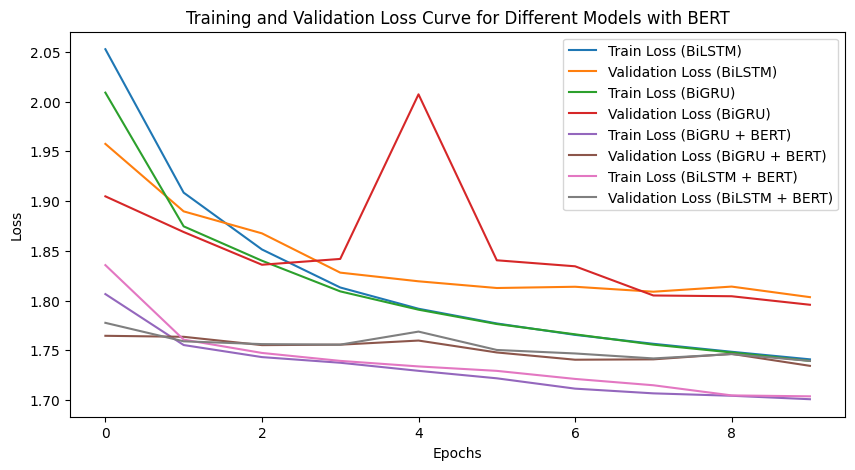

BiLSTM 驗證準確度 0.74
BiGRU 驗證準確度 0.75
BiLSTM + BERT 驗證準確度 0.80
BiGRU + BERT 驗證準確度 0.81


In [ ]:
import bigru
import bilstm
import bert_bigru
import bert_bilstm

import matplotlib.pyplot as plt




lstm = bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
gru = bigru.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
bertbigru = bert_bigru.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
bertbilstm = bert_bilstm.NewsClassificationPipeline(data_path='Processed.json', num_epochs=10 , feature=['headline','short_description'])
bertbilstm.run()
lstm.run()
gru.run()
bertbigru.run()

train_loss_lstm = lstm.train_loss
val_loss_lstm  = lstm.val_loss

train_loss_gru = gru.train_loss
val_loss_gru = gru.val_loss

train_loss_bertbigru = bertbigru.train_loss
val_loss_bertbigru = bertbigru.val_loss

train_loss_bertbilstm = bertbilstm.train_loss
val_loss_bertbilstm = bertbilstm.val_loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_lstm, label='Train Loss (BiLSTM)')
plt.plot(val_loss_lstm, label='Validation Loss (BiLSTM)')
plt.plot(train_loss_gru, label='Train Loss (BiGRU)')
plt.plot(val_loss_gru, label='Validation Loss (BiGRU)')
plt.plot(train_loss_bertbigru, label='Train Loss (BiGRU + BERT)')
plt.plot(val_loss_bertbigru, label='Validation Loss (BiGRU + BERT)')
plt.plot(train_loss_bertbilstm, label='Train Loss (BiLSTM + BERT)')
plt.plot(val_loss_bertbilstm, label='Validation Loss (BiLSTM + BERT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for Different Models with BERT')
plt.legend()
plt.show()
print("BiLSTM 驗證準確度 %.2f" % lstm.val_accuracy)
print("BiGRU 驗證準確度 %.2f" % gru.val_accuracy)
print("BiLSTM + BERT 驗證準確度 %.2f" % bertbilstm.val_accuracy)
print("BiGRU + BERT 驗證準確度 %.2f" % bertbigru.val_accuracy)


# 基於 LLM 的文本分類：3-shot CoT（Chain of Thought）

本區演示如何使用大型語言模型（LLM）進行文本分類，並結合 3-shot Chain of Thought（CoT）推理策略。實現方法參考了[這篇論文](https://arxiv.org/abs/2305.08377)中的描述
並比較直接prompt區別。

## 模型
使用的模型為 **GPT-4o-mini-2024-07-18**，



In [ ]:
from openai import OpenAI
import random
api_key = 'apikey'

client = OpenAI(api_key=api_key)  # This is the default and can be omitted


def get_category_3shotcot(Headline, Short_Description):
    try:
        # 使用 OpenAI ChatCompletion 接口進行請求
        completion = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies news articles into categories with reasoning and context."},
                {
                    "role": "user",
                    "content": f"""
                    Classify the following news headline and short description into one of these categories: 
                    COMEDY, PARENTING, ENTERTAINMENT, POLITICS, WELLNESS, BUSINESS, STYLE & BEAUTY, FOOD & DRINK, QUEER VOICES, TRAVEL, HEALTHY LIVING.

                    For each classification:
                    - Extract key clues from the text.
                    - Provide reasoning for the chosen category.
                    - Provide the final label (GOLDLABEL).

                    Here are three examples to guide you:

                    1. Headline: "A Stand-Up Comedian's Viral Joke"  
                       Short Description: "A hilarious take on modern dating goes viral."  
                       CLUES: ["comedian", "joke", "viral", "hilarious"]  
                       REASONING: "The topic is centered on comedy and humor, highlighting a comedian's joke."  
                       GOLDLABEL: "COMEDY"

                    2. Headline: "5 Tips for Traveling Solo Safely"  
                       Short Description: "Make the most of your solo trip with these essential safety tips."  
                       CLUES: ["traveling", "solo", "safety"]  
                       REASONING: "The content provides travel advice, clearly fitting into the travel category."  
                       GOLDLABEL: "TRAVEL"

                    3. Headline: "The Challenges of Raising Twins"  
                       Short Description: "One mom shares her story of parenting twins during a pandemic."  
                       CLUES: ["parenting", "twins", "mom", "pandemic"]  
                       REASONING: "The focus is on parenting and raising children, specifically the experience of raising twins."  
                       GOLDLABEL: "PARENTING"

                    Now classify the input based on these examples.

                    **Input**:
                    - Headline: "{Headline}"
                    - Short Description: "{Short_Description}"

                    **Output**:
                    - CLUES: [Extracted key clues]
                    - REASONING: [Detailed reasoning for the chosen category]
                    - GOLDLABEL: [Final category label]
                    """
                }
            ]
        )
        valid_labels = [
            "COMEDY", "PARENTING", "ENTERTAINMENT", "POLITICS", "WELLNESS",
            "BUSINESS", "STYLE & BEAUTY", "FOOD & DRINK", "QUEER VOICES",
            "TRAVEL", "HEALTHY LIVING"
        ]
        # 提取返回值並清理
        data = completion.choices[0].message.content.strip()
        for each in valid_labels :
                if each in data :
                    return each
        return random.choice(valid_labels)

    except Exception as e:
        return f"Error: {str(e)}"


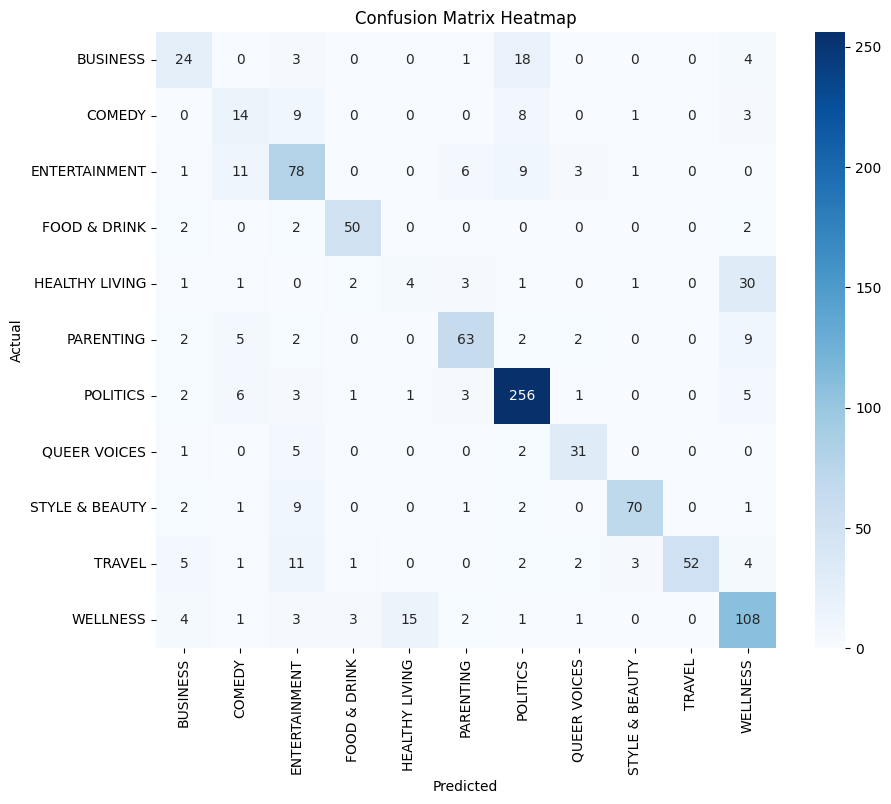

Accuracy: 0.75


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load the data
data = pd.read_json('Origin.json')

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.01, random_state=42)
#只取前1000個 3SHOT執行約0.15$
test_data = test_data[:1000]
# Apply the get_catagory function to the test data
test_data['predicted_category'] = test_data.apply(lambda row: get_category_3shotcot(row['headline'], row['short_description']), axis=1)

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(test_data['category'], test_data['predicted_category'], rownames=['Actual'], colnames=['Predicted'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Calculate accuracy
correct_predictions = (test_data['category'] == test_data['predicted_category']).sum()
accuracy = correct_predictions / len(test_data)
print(f"Accuracy: {accuracy:.2f}")